In [72]:
# !unzip /content/Test.zip

In [73]:
# !git clone https://github.com/nataliacampiglia/ml-ia-obligatorio.git
# %cd ml-ia-obligatorio
# !git pull
# !git checkout main

In [74]:
# Test Path
testPath = 'Test'

# In colob testPath is
# testPath = 'content/Test'

In [75]:
import os
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from skimage import feature
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from itertools import chain
from sklearn.metrics import accuracy_score  # or f1_score, etc.
from sklearn.metrics import classification_report

In [76]:
from utils import create_images_list
from pca_helper import prepare_data, process_test_images

In [77]:
suffix = '.pgm'
kaggle_files = os.listdir(testPath)
pgm_kaggle_files = [filename for filename in kaggle_files if filename.endswith(suffix)]

In [78]:
len(pgm_kaggle_files)

8000

In [79]:
kaggle_patches = []
for filename in tqdm(pgm_kaggle_files):
  path = testPath + '/' + filename
  with open(path, 'rb') as pgmf:
      image = plt.imread(pgmf)
  kaggle_patches.append(image)

100%|██████████| 8000/8000 [00:01<00:00, 4321.56it/s]


In [80]:
pgm_kaggle_files_id = []

for filename in tqdm(pgm_kaggle_files):
  pgm_kaggle_files_id.append(filename[5:-4])

100%|██████████| 8000/8000 [00:00<00:00, 2344660.19it/s]


# Preprocesamiento de los datos

Obtenemos Faces y backgorunds

In [81]:
facesPath = 'Faces' # use '/content/Faces' on colab
faces = create_images_list([facesPath])
faces.shape

100%|██████████| 12833/12833 [00:01<00:00, 8778.60it/s] 


(12833, 64, 64)

In [82]:
from constants import (BACKGROUND_PATH)
backgrounds = create_images_list([BACKGROUND_PATH])
backgrounds.shape


100%|██████████| 12800/12800 [00:01<00:00, 11731.67it/s]


(12800, 64, 64)

# PCA

In [83]:
X_train_pca, X_test, y_train, y_test, scaler, pca = prepare_data(faces, backgrounds, test_size=0.3, random_state=42, use_hog=False)

Construyendo X: 25633it [00:00, 618863.01it/s]


In [84]:
# print shape of X_train_pca, X_test, y_train, y_test, scaler, pca
print(f"X_train_pca shape: {X_train_pca.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")
print(f"scaler shape: {scaler}")
print(f"pca shape: {pca}")

X_train_pca shape: (17943, 500)
X_test shape: (7690, 4096)
y_train shape: (17943,)
y_test shape: (7690,)
scaler shape: StandardScaler()
pca shape: PCA(n_components=500)


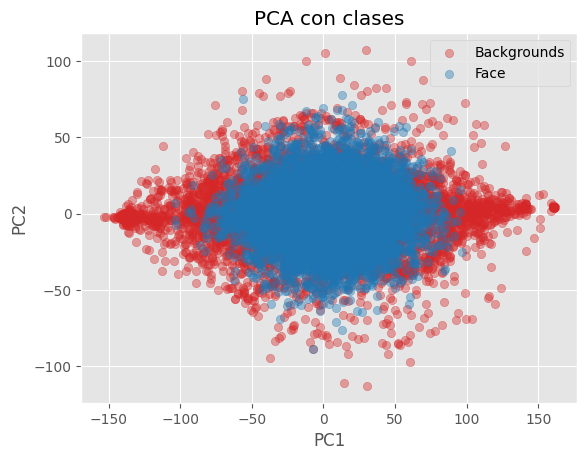

In [85]:
# Graficar con colores y leyenda
colors = ['tab:red', 'tab:blue']
labels = ['Backgrounds', 'Face']

for class_value in [0, 1]:
    plt.scatter(
        X_train_pca[y_train == class_value, 0],
        X_train_pca[y_train == class_value, 1],
        c=colors[class_value],
        label=labels[class_value],
        alpha=0.4
    )

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA con clases')
plt.legend()
plt.grid(True)
plt.show()

In [86]:
gaussianModel = GaussianNB()
gaussianModel.fit(X_train_pca, y_train)

GaussianNB()

In [87]:
y_train_pred = gaussianModel.predict(X_train_pca)
print(classification_report(y_train, y_train_pred))

# Estandarizar y transformar datos de test
scaler = StandardScaler()
X_test_std = scaler.fit_transform(X_test)
X_test_pca = pca.transform(X_test_std)

y_test_pred = gaussianModel.predict(X_test_pca)

print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

         0.0       0.66      0.41      0.51      8990
         1.0       0.57      0.79      0.66      8953

    accuracy                           0.60     17943
   macro avg       0.62      0.60      0.58     17943
weighted avg       0.62      0.60      0.58     17943

              precision    recall  f1-score   support

         0.0       0.64      0.41      0.50      3810
         1.0       0.57      0.78      0.66      3880

    accuracy                           0.59      7690
   macro avg       0.61      0.59      0.58      7690
weighted avg       0.61      0.59      0.58      7690



In [88]:
X_pca_kag = process_test_images(kaggle_patches, scaler, pca, use_hog=False)
# Predicción
y_kag = gaussianModel.predict(X_pca_kag)

# Evaluate
X_test_std = scaler.transform(X_test)
X_test_pca = pca.transform(X_test_std)

y_test_pred = gaussianModel.predict(X_test_pca)
score = accuracy_score(y_test, y_test_pred)
print("Validation Accuracy:", score)

Procesando imágenes de prueba: 100%|██████████| 8000/8000 [00:00<00:00, 488369.92it/s]


Validation Accuracy: 0.5934980494148244


In [89]:
y_kag_dic = {pgm_kaggle_files_id[i]: y_kag[i] for i in range(len(pgm_kaggle_files_id))}
kaggle_hat = pd.DataFrame(list(y_kag_dic.items()), columns=['id', 'target_feature'])
kaggle_hat['id'] = kaggle_hat['id'].astype(int)
kaggle_hat['target_feature'] = kaggle_hat['target_feature'].astype(int)
kaggle_hat.sort_values(by='id', inplace=True)
kaggle_hat.head()

,id,target_feature
1379,0,0
7084,1,0
5414,2,1
2021,3,1
4396,4,0


In [90]:
# Guardamos en un .csv para subir a kaggle
submission_name = 'pca_submition'
kaggle_hat.to_csv(submission_name + '.csv', index=False)

# Kaggle result

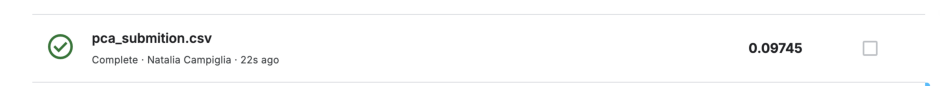

In [91]:
import matplotlib.pyplot as plt

img = plt.imread('kaggle_submissions/pca_submition.png')
plt.figure(figsize=(12, 12))
plt.imshow(img)
plt.axis('off')
plt.show()

# HOG

In [92]:
# use prepare_data to get X_train_pca, X_test, y_train, y_test, scaler, pca
X_train_pca, X_test, y_train, y_test, scaler, pca = prepare_data(faces, backgrounds, test_size=0.3, random_state=42)

Construyendo X: 25633it [00:27, 927.03it/s]


In [93]:
# print shape of X_train_pca, X_test, y_train, y_test, scaler, pca
print(f"X_train_pca shape: {X_train_pca.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")
print(f"scaler shape: {scaler}")
print(f"pca shape: {pca}")

X_train_pca shape: (17943, 500)
X_test shape: (7690, 2916)
y_train shape: (17943,)
y_test shape: (7690,)
scaler shape: StandardScaler()
pca shape: PCA(n_components=500)


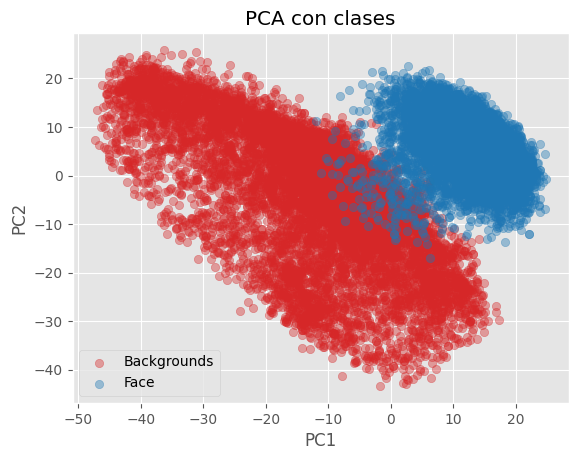

In [94]:
# Graficar con colores y leyenda
colors = ['tab:red', 'tab:blue']
labels = ['Backgrounds', 'Face']

for class_value in [0, 1]:
    plt.scatter(
        X_train_pca[y_train == class_value, 0],
        X_train_pca[y_train == class_value, 1],
        c=colors[class_value],
        label=labels[class_value],
        alpha=0.4
    )

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA con clases')
plt.legend()
plt.grid(True)
plt.show()

In [95]:
gaussianModel = GaussianNB()
gaussianModel.fit(X_train_pca, y_train)
y_train_pred = gaussianModel.predict(X_train_pca)
print(classification_report(y_train, y_train_pred))

# Estandarizar y transformar datos de test
scaler = StandardScaler()
X_test_std = scaler.fit_transform(X_test)
X_test_pca = pca.transform(X_test_std)

y_test_pred = gaussianModel.predict(X_test_pca)

print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

         0.0       0.94      0.97      0.95      8990
         1.0       0.97      0.94      0.95      8953

    accuracy                           0.95     17943
   macro avg       0.95      0.95      0.95     17943
weighted avg       0.95      0.95      0.95     17943

              precision    recall  f1-score   support

         0.0       0.94      0.98      0.96      3810
         1.0       0.98      0.93      0.95      3880

    accuracy                           0.95      7690
   macro avg       0.96      0.96      0.95      7690
weighted avg       0.96      0.95      0.95      7690



In [96]:
X_pca_kag = process_test_images(kaggle_patches, scaler, pca)
# Predicción
y_kag = gaussianModel.predict(X_pca_kag)

# Evaluate
X_test_std = scaler.transform(X_test)
X_test_pca = pca.transform(X_test_std)

y_test_pred = gaussianModel.predict(X_test_pca)
score = accuracy_score(y_test, y_test_pred)
print("Validation Accuracy:", score)

Procesando imágenes de prueba: 100%|██████████| 8000/8000 [00:08<00:00, 899.53it/s] 


Validation Accuracy: 0.9548764629388816


In [97]:
y_kag_dic = {pgm_kaggle_files_id[i]: y_kag[i] for i in range(len(pgm_kaggle_files_id))}
kaggle_hat = pd.DataFrame(list(y_kag_dic.items()), columns=['id', 'target_feature'])
kaggle_hat['id'] = kaggle_hat['id'].astype(int)
kaggle_hat['target_feature'] = kaggle_hat['target_feature'].astype(int)
kaggle_hat.sort_values(by='id', inplace=True)
kaggle_hat.head()

,id,target_feature
1379,0,0
7084,1,0
5414,2,0
2021,3,0
4396,4,0


In [98]:
# Guardamos en un .csv para subir a kaggle
submission_name = 'hog_submition'
kaggle_hat.to_csv(submission_name + '.csv', index=False)

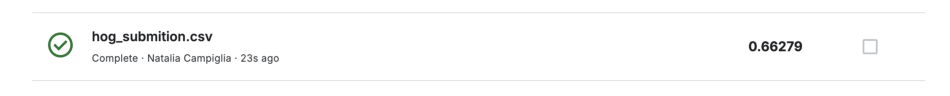

In [99]:
import matplotlib.pyplot as plt

img = plt.imread('kaggle_submissions/hog_submission.png')
plt.figure(figsize=(12, 12))
plt.imshow(img)
plt.axis('off')
plt.show()

# Models

In [121]:
from sklearn.metrics import roc_curve, auc, confusion_matrix, roc_auc_score
import numpy as np
import matplotlib.pyplot as plt

def compute_metrics(y_true, y_pred_probs, threshold=0.5, model_name="Model"):
    # Umbral para clases
    y_pred_classes = (y_pred_probs > threshold).astype(int).flatten()

    # Matriz de confusión
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred_classes).ravel()

    # TPR, FPR
    TPR = tp / (tp + fn)
    FPR = fp / (fp + tn)
    TNR = tn / (tn + fp)
    GMean = np.sqrt(TPR * TNR)

    # ROC curve & AUC
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_probs)
    roc_auc = auc(fpr, tpr)

    # Reporte
    print(f"\n=== {model_name} ===")
    print(f"TPR (Recall): {TPR:.4f}")
    print(f"FPR: {FPR:.4f}")
    print(f"AUC: {roc_auc:.4f}")
    print(f"G-Mean: {GMean:.4f}")

    # Graficar curva ROC
    plt.figure()
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {model_name}')
    plt.legend(loc='lower right')
    plt.show()

    return {
        "TPR": TPR,
        "FPR": FPR,
        "AUC": roc_auc,
        "GMean": GMean
    }


In [100]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import roc_auc_score, classification_report

In [101]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


### Random Forest

Random Forest es una excelente elección para este problema de clasificación de imágenes por varias razones:

1. **Manejo de Dimensionalidad**:
   - Después de aplicar PCA, nuestros datos siguen teniendo 500 dimensiones
   - Random Forest maneja bien datos de alta dimensionalidad sin necesidad de normalización adicional
   - Cada árbol en el bosque puede seleccionar diferentes subconjuntos de características

2. **Robustez**:
   - Es menos propenso al overfitting que modelos individuales
   - La combinación de múltiples árboles reduce la varianza
   - Maneja bien el ruido en los datos de imágenes

3. **Características no lineales**:
   - Puede capturar relaciones no lineales entre características
   - Importante para reconocimiento de patrones en imágenes
   - No requiere transformaciones adicionales de los datos

4. **Interpretabilidad**:
   - Proporciona importancia de características
   - Permite entender qué aspectos de las imágenes son más relevantes
   - Útil para análisis y mejoras del modelo

5. **Rendimiento**:
   - Como vemos en los resultados, alcanza una precisión del 98% en el conjunto de validación
   - Buen balance entre precisión y recall para ambas clases
   - F1-score de 0.98 indica un buen equilibrio entre precisión y recall

6. **Eficiencia computacional**:
   - Entrenamiento paralelizable
   - Predicciones rápidas
   - Escalable a grandes conjuntos de datos

7. **Manejo de desbalanceo**:
   - Puede manejar clases desbalanceadas
   - Útil si las clases de imágenes no están perfectamente balanceadas
   - Permite ajustar pesos de clases si es necesario

In [102]:
X_train_pca, X_test, y_train, y_test, scaler, pca = prepare_data(faces, backgrounds, test_size=0.3, random_state=42)

Construyendo X: 25633it [00:26, 955.59it/s]


In [103]:
from sklearn.ensemble import RandomForestClassifier

# Define el modelo base
rf = RandomForestClassifier(random_state=42)
# Define la grilla de hiperparámetros
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 15, 30],
    'max_features': ['sqrt', 'log2']
}

# Configura GridSearchCV
grid_rf = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=cv,
    scoring='roc_auc',   # o 'accuracy'
    n_jobs=-1,
    verbose=2
)

# Entrena
grid_rf.fit(X_train_pca, y_train)

print("Mejores hiperparámetros:", grid_rf.best_params_)
print("Mejor AUC (CV):", grid_rf.best_score_)


Fitting 5 folds for each of 18 candidates, totalling 90 fits
Mejores hiperparámetros: {'max_depth': None, 'max_features': 'sqrt', 'n_estimators': 200}
Mejor AUC (CV): 0.9983704932104063


In [104]:
scaler = StandardScaler()
X_test_std = scaler.fit_transform(X_test)
X_test_pca = pca.transform(X_test_std)

# Predice en test con el mejor modelo
y_pred_rf = grid_rf.predict(X_test_pca)
print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

         0.0       0.97      1.00      0.99      3810
         1.0       1.00      0.97      0.99      3880

    accuracy                           0.99      7690
   macro avg       0.99      0.99      0.99      7690
weighted avg       0.99      0.99      0.99      7690



In [105]:
cv_results = pd.DataFrame(grid_rf.cv_results_)

In [106]:
print(cv_results.columns)

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_max_depth', 'param_max_features', 'param_n_estimators', 'params',
       'split0_test_score', 'split1_test_score', 'split2_test_score',
       'split3_test_score', 'split4_test_score', 'mean_test_score',
       'std_test_score', 'rank_test_score'],
      dtype='object')


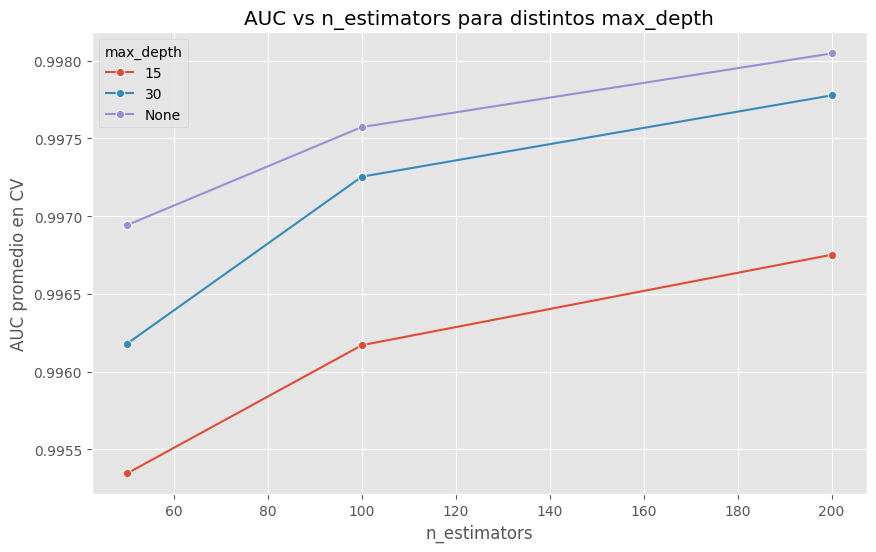

In [107]:
# Agrupa por n_estimators y max_depth
cv_results['param_max_depth'] = cv_results['param_max_depth'].astype(str)

grouped = cv_results.groupby(['param_n_estimators', 'param_max_depth']).mean_test_score.mean().reset_index()

# Plot
import seaborn as sns

plt.figure(figsize=(10,6))
sns.lineplot(
    data=grouped,
    x='param_n_estimators',
    y='mean_test_score',
    hue='param_max_depth',
    marker='o'
)
plt.xlabel('n_estimators')
plt.ylabel('AUC promedio en CV')
plt.title('AUC vs n_estimators para distintos max_depth')
plt.legend(title='max_depth')
plt.grid(True)
plt.show()

In [120]:
# Aquí debe utilizar su modelo
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(n_estimators=200, random_state=42)
rf_model.fit(X_train_pca, y_train)

RandomForestClassifier(n_estimators=200, random_state=42)

In [122]:
y_train_pred = rf_model.predict(X_train_pca)
print(classification_report(y_train, y_train_pred))

# Estandarizar y transformar datos de test
scaler = StandardScaler()
X_test_std = scaler.fit_transform(X_test)
X_test_pca = pca.transform(X_test_std)

y_test_pred = rf_model.predict(X_test_pca)

print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      8990
         1.0       1.00      1.00      1.00      8953

    accuracy                           1.00     17943
   macro avg       1.00      1.00      1.00     17943
weighted avg       1.00      1.00      1.00     17943

              precision    recall  f1-score   support

         0.0       0.97      1.00      0.99      3810
         1.0       1.00      0.97      0.99      3880

    accuracy                           0.99      7690
   macro avg       0.99      0.99      0.99      7690
weighted avg       0.99      0.99      0.99      7690




=== Random Forest ===
TPR (Recall): 0.9711
FPR: 0.0000
AUC: 0.9988
G-Mean: 0.9855


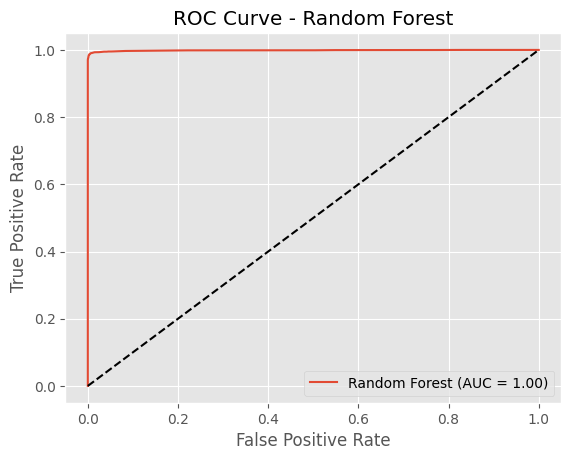

In [124]:
# Suponiendo que tienes probabilidades:
y_rf_probs = rf_model.predict_proba(X_test_pca)[:, 1]

metrics_rf = compute_metrics(y_test, y_rf_probs, model_name="Random Forest")

In [110]:
# Aquí debe procesar las imagenes de pgm_kaggle_files
X_pca_kag = process_test_images(kaggle_patches, scaler, pca)

Procesando imágenes de prueba: 100%|██████████| 8000/8000 [00:09<00:00, 879.68it/s] 


In [111]:
# Predicción
y_kag = rf_model.predict(X_pca_kag)

In [112]:
# Evaluate
X_test_std = scaler.transform(X_test)
X_test_pca = pca.transform(X_test_std)

y_test_pred = rf_model.predict(X_test_pca)
score = accuracy_score(y_test, y_test_pred)
print("Validation Accuracy:", score)


Validation Accuracy: 0.9854356306892068


In [113]:
# Predicción + ID
y_kag_dic = {pgm_kaggle_files_id[i]: y_kag[i] for i in range(len(pgm_kaggle_files_id))}
kaggle_hat = pd.DataFrame(list(y_kag_dic.items()), columns=['id', 'target_feature'])
kaggle_hat['id'] = kaggle_hat['id'].astype(int)
kaggle_hat['target_feature'] = kaggle_hat['target_feature'].astype(int)
kaggle_hat.sort_values(by='id', inplace=True)

In [114]:
kaggle_hat.head()

,id,target_feature
1379,0,0
7084,1,0
5414,2,0
2021,3,0
4396,4,0


In [115]:
# Guardamos en un .csv para subir a kaggle
submission_name = 'submission_RandomForestClassifier'
kaggle_hat.to_csv(submission_name + '.csv', index=False)

In [116]:
X_pca_kag = process_test_images(kaggle_patches, scaler, pca)
y_kag = rf_model.predict(X_pca_kag)
# Evaluate
X_test_std = scaler.transform(X_test)
X_test_pca = pca.transform(X_test_std)

y_test_pred = rf_model.predict(X_test_pca)
score = accuracy_score(y_test, y_test_pred)
print("Validation Accuracy:", score)

# Predicción + ID
y_kag_dic = {pgm_kaggle_files_id[i]: y_kag[i] for i in range(len(pgm_kaggle_files_id))}
kaggle_hat = pd.DataFrame(list(y_kag_dic.items()), columns=['id', 'target_feature'])
kaggle_hat['id'] = kaggle_hat['id'].astype(int)
kaggle_hat['target_feature'] = kaggle_hat['target_feature'].astype(int)
kaggle_hat.sort_values(by='id', inplace=True)

kaggle_hat.head()

# Guardamos en un .csv para subir a kaggle
submission_name = 'submission_RandomForestClassifier'
kaggle_hat.to_csv(submission_name + '.csv', index=False)


Procesando imágenes de prueba: 100%|██████████| 8000/8000 [00:08<00:00, 947.25it/s] 


Validation Accuracy: 0.9854356306892068


### Baggin

In [117]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier

# Árbol de decisión simple como base estimator
base_estimator = DecisionTreeClassifier(random_state=42)

# Metaestimador Bagging
bagging = BaggingClassifier(
    estimator=base_estimator,
    random_state=42
)

In [118]:
param_grid_bagging = {
    'n_estimators': [50, 100],
    'estimator__max_depth': [10, None],  # max_depth del árbol base
    'bootstrap': [True, False]
}

In [119]:
grid_bagging = GridSearchCV(
    estimator=bagging,
    param_grid=param_grid_bagging,
    cv=cv,
    scoring='roc_auc',   # o 'accuracy'
    n_jobs=-1,
    verbose=2
)

grid_bagging.fit(X_train_pca, y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


KeyboardInterrupt: 

In [ ]:
print("Mejores hiperparámetros:", grid_bagging.best_params_)
print("Mejor AUC (CV):", grid_bagging.best_score_)

In [ ]:
print("Mejores hiperparámetros:", grid_bagging.best_params_)
print("Mejor AUC (CV):", grid_bagging.best_score_)

scaler = StandardScaler()
X_test_std = scaler.fit_transform(X_test)
X_test_pca = pca.transform(X_test_std)


# Predicción final en test
y_pred_bagging = grid_bagging.predict(X_test_pca)
print(classification_report(y_test, y_pred_bagging))

In [125]:
bagging_model = BaggingClassifier(
    estimator=DecisionTreeClassifier(max_depth=10),
    bootstrap=True,
    n_estimators=100,
)

bagging_model.fit(X_train_pca, y_train)

BaggingClassifier(estimator=DecisionTreeClassifier(max_depth=10),
                  n_estimators=100)

In [126]:
y_train_pred = bagging_model.predict(X_train_pca)
print(classification_report(y_train, y_train_pred))

# Estandarizar y transformar datos de test
scaler = StandardScaler()
X_test_std = scaler.fit_transform(X_test)
X_test_pca = pca.transform(X_test_std)

y_test_pred = bagging_model.predict(X_test_pca)

print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

         0.0       0.99      1.00      1.00      8990
         1.0       1.00      0.99      1.00      8953

    accuracy                           1.00     17943
   macro avg       1.00      1.00      1.00     17943
weighted avg       1.00      1.00      1.00     17943

              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99      3810
         1.0       1.00      0.99      0.99      3880

    accuracy                           0.99      7690
   macro avg       0.99      0.99      0.99      7690
weighted avg       0.99      0.99      0.99      7690



In [127]:
# Aquí debe procesar las imagenes de pgm_kaggle_files
X_pca_kag = process_test_images(kaggle_patches, scaler, pca)

Procesando imágenes de prueba: 100%|██████████| 8000/8000 [00:08<00:00, 932.66it/s] 


In [128]:
y_kag = bagging_model.predict(X_pca_kag)

In [129]:
# Evaluate
X_test_std = scaler.transform(X_test)
X_test_pca = pca.transform(X_test_std)

y_test_pred = bagging_model.predict(X_test_pca)
score = accuracy_score(y_test, y_test_pred)
print("Validation Accuracy:", score)

Validation Accuracy: 0.9910273081924578



=== Bagging ===
TPR (Recall): 0.9871
FPR: 0.0050
AUC: 0.9987
G-Mean: 0.9911


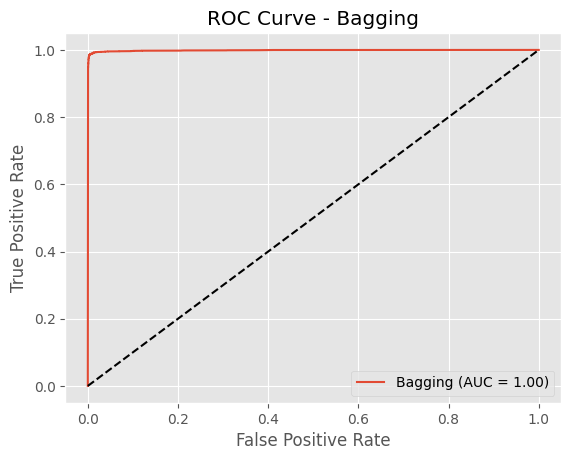

In [130]:
y_bagging_probs = bagging_model.predict_proba(X_test_pca)[:, 1]

metrics_bagging = compute_metrics(y_test, y_bagging_probs, model_name="Bagging")


In [ ]:
# Predicción + ID
y_kag_dic = {pgm_kaggle_files_id[i]: y_kag[i] for i in range(len(pgm_kaggle_files_id))}
kaggle_hat = pd.DataFrame(list(y_kag_dic.items()), columns=['id', 'target_feature'])
kaggle_hat['id'] = kaggle_hat['id'].astype(int)
kaggle_hat['target_feature'] = kaggle_hat['target_feature'].astype(int)
kaggle_hat.sort_values(by='id', inplace=True)

In [ ]:
kaggle_hat.head()

In [ ]:
# Guardamos en un .csv para subir a kaggle
submission_name = 'submission_BaggingClassifier'
kaggle_hat.to_csv(submission_name + '.csv', index=False)

# Redes Neuronales

In [131]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Define la red neuronal
model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=(X_train_pca.shape[1],)),  # Capa oculta 1
    layers.Dense(32, activation='relu'),  # Capa oculta 2
    layers.Dense(1, activation='sigmoid')  # Capa de salida para clasificación binaria
])

# Compila
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',  # Clave: para clasificación binaria
    metrics=['accuracy']
)

# Entrena
history = model.fit(
    X_train_pca, y_train,
    validation_data=(X_test_pca, y_test),
    epochs=50,
    batch_size=32
)

# Evalúa
loss, accuracy = model.evaluate(X_test_pca, y_test)
print(f"Test accuracy: {accuracy:.4f}")


Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


561/561 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9262 - loss: 0.1641 - val_accuracy: 0.9930 - val_loss: 0.0212
Epoch 2/50
561/561 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9987 - loss: 0.0057 - val_accuracy: 0.9951 - val_loss: 0.0185
Epoch 3/50
561/561 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 1.0000 - loss: 4.5878e-04 - val_accuracy: 0.9952 - val_loss: 0.0172
Epoch 4/50
561/561 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 1.0000 - loss: 1.4149e-04 - val_accuracy: 0.9952 - val_loss: 0.0182
Epoch 5/50
561/561 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 1.0000 - loss: 7.2768e-05 - val_accuracy: 0.9953 - val_loss: 0.0186
Epoch 6/50
561/561 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 1.0000 - loss: 4.6550e-05 - val_accuracy: 0.9953 - val_loss: 0.0189
Epoch 7/50
561/561 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 1.0000 - loss: 2.9491e-05 - val_accuracy: 0.9954 - val_loss: 0.0195
Epoch 8/50
561/561 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 1.0000 - loss: 2.0720e-05 - val

In [143]:
scaler = StandardScaler()
X_test_std = scaler.fit_transform(X_test)
X_test_pca = pca.transform(X_test_std)

241/241 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step

=== Red Neuronal ===
TPR (Recall): 0.9941
FPR: 0.0018
AUC: 0.9997
G-Mean: 0.9961


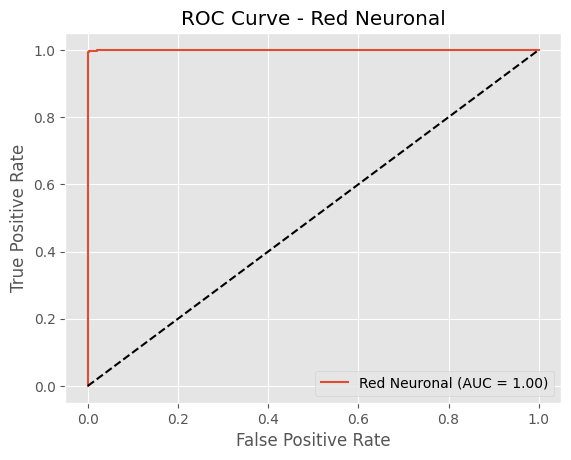

In [144]:
y_nn_probs = model.predict(X_test_pca)  # Ya da probas
metrics_nn = compute_metrics(y_test, y_nn_probs, model_name="Red Neuronal")

In [ ]:
# ⚡ Preprocesar test para Kaggle
X_pca_kag = process_test_images(kaggle_patches, scaler, pca)

# ⚡ Predicciones con la red neuronal
y_kag_probs = model.predict(X_pca_kag)
y_kag = (y_kag_probs > 0.5).astype(int).flatten()


In [ ]:
# ⚡ (Opcional) Evalúa en tu test interno para comparar
X_test_std = scaler.transform(X_test)
X_test_pca = pca.transform(X_test_std)
y_test_probs = model.predict(X_test_pca)
y_test_pred = (y_test_probs > 0.5).astype(int).flatten()

from sklearn.metrics import accuracy_score
score = accuracy_score(y_test, y_test_pred)
print("Validation Accuracy:", score)



In [ ]:
# ⚡ Combina ID + predicción
y_kag_dic = {pgm_kaggle_files_id[i]: y_kag[i] for i in range(len(pgm_kaggle_files_id))}
kaggle_hat = pd.DataFrame(list(y_kag_dic.items()), columns=['id', 'target_feature'])
kaggle_hat['id'] = kaggle_hat['id'].astype(int)
kaggle_hat['target_feature'] = kaggle_hat['target_feature'].astype(int)
kaggle_hat.sort_values(by='id', inplace=True)


In [ ]:
kaggle_hat.head()

In [ ]:



# ⚡ Guarda CSV para Kaggle
submission_name = 'submission_NeuralNetwork'
kaggle_hat.to_csv(submission_name + '.csv', index=False)
print(f"Archivo {submission_name}.csv listo para subir a Kaggle 🚀")

In [137]:
results = pd.DataFrame([
    {"Model": "Random Forest", **metrics_rf},
    {"Model": "Bagging", **metrics_bagging},
    {"Model": "Red Neuronal", **metrics_nn}
])

results = results.round(4)
results

,Model,TPR,FPR,AUC,GMean
0,Random Forest,0.9711,0.0000,0.9988,0.9855
1,Bagging,0.9871,0.0050,0.9987,0.9911
2,Red Neuronal,0.9941,0.0018,0.9997,0.9961


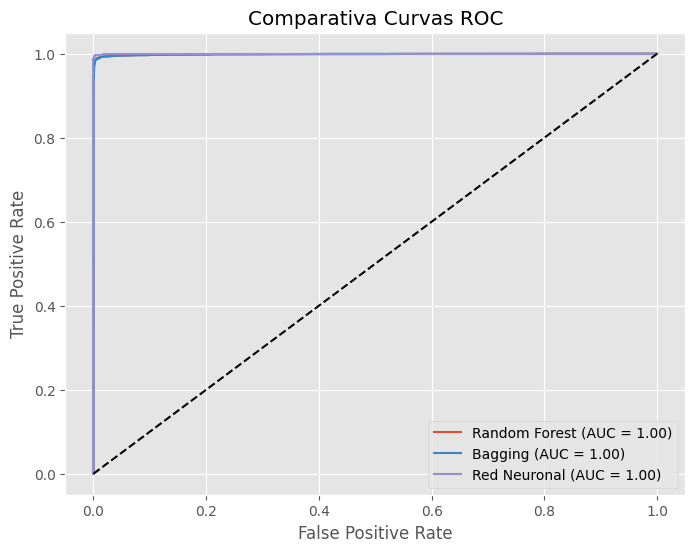

In [138]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))

# Random Forest
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_rf_probs)
plt.plot(fpr_rf, tpr_rf, label=f"Random Forest (AUC = {metrics_rf['AUC']:.2f})")

# Bagging
fpr_bag, tpr_bag, _ = roc_curve(y_test, y_bagging_probs)
plt.plot(fpr_bag, tpr_bag, label=f"Bagging (AUC = {metrics_bagging['AUC']:.2f})")

# Red Neuronal
fpr_nn, tpr_nn, _ = roc_curve(y_test, y_nn_probs)
plt.plot(fpr_nn, tpr_nn, label=f"Red Neuronal (AUC = {metrics_nn['AUC']:.2f})")

# Línea diagonal
plt.plot([0,1], [0,1], 'k--')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Comparativa Curvas ROC')
plt.legend(loc='lower right')
plt.show()

In [140]:
print(results.columns.tolist())

['Model', 'TPR', 'FPR', 'AUC', 'GMean']


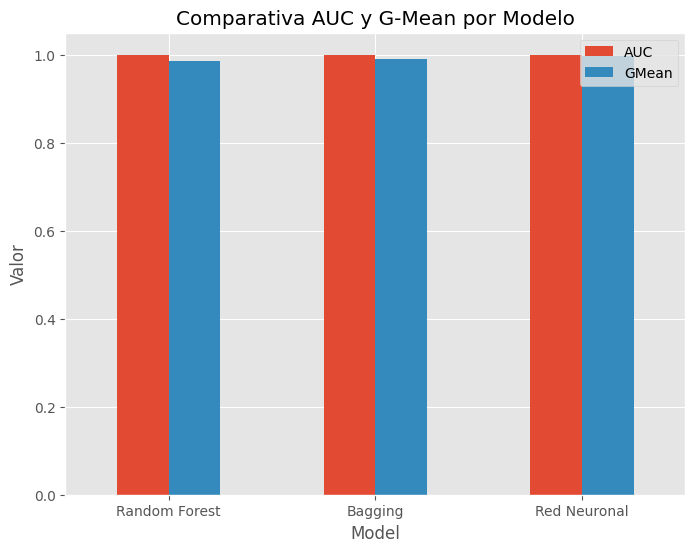

In [141]:
results.plot(x='Model', y=['AUC', 'GMean'], kind='bar', figsize=(8,6))
plt.title('Comparativa AUC y G-Mean por Modelo')
plt.ylabel('Valor')
plt.xticks(rotation=0)
plt.show()